In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm
import tensorflow
tensorflow.random.set_seed(23)
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.constraints import Constraint
from keras import backend
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, Concatenate,BatchNormalization,Add,ZeroPadding2D, ReLU
from tensorflow.keras import initializers, optimizers
from tensorflow.keras.models import Model
from numpy import ones, zeros
from tensorflow.keras.utils import plot_model

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

files = os.listdir('../input/landscape-image-colorization/landscape Images/color')
files = sorted_alphanumeric(files)

Enter a number between 0 and 7129:  543


543
(150, 150, 3)


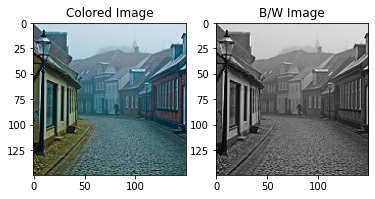

(150, 150, 3)


In [3]:
ran = int(input('Enter a number between 0 and {}: '.format(len(files))))
print(ran)
img = load_img('../input/landscape-image-colorization/landscape Images/color/'+str(ran)+'.jpg')
plt.subplot(121)
plt.imshow(img)
plt.title('Colored Image')
print(img_to_array(img).shape)

img = load_img('../input/landscape-image-colorization/landscape Images/gray/'+str(ran)+'.jpg')
plt.subplot(122)
plt.imshow(img)
plt.title('B/W Image')
plt.show()
print(img_to_array(img).shape)

In [4]:
bw_img = []
path = '../input/landscape-image-colorization/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
print('No. of b/w images', str(len(files)))
for file in tqdm(files):
    img = load_img(path + '/'+file, target_size=(150,150))
    img = (img_to_array(img) - 127.5)/127.5
    bw_img.append(img)
    
color_img =[]
path = '../input/landscape-image-colorization/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
print('No. of colored images', str(len(files)))
for file in tqdm(files):
    img = load_img(path + '/'+file, target_size=(150,150))
    img = (img_to_array(img) - 127.5)/127.5
    color_img.append(img)
    
color_img = np.array(color_img).astype('float16')
bw_img = np.array(bw_img).astype('float16')

No. of b/w images 7129


100%|██████████| 7129/7129 [00:31<00:00, 227.76it/s]


No. of colored images 7129


100%|██████████| 7129/7129 [00:33<00:00, 211.70it/s]


In [10]:
def plott(data_c, data_g):
    n = np.random.randint(1000)
    pred = gen_update_model.layers[1].predict(data_g[n].reshape((1,150,150,3)))
    pred = (pred*127.5)+127.5
    pred = pred/255.
    plt.figure(figsize=(20,10))

    plt.subplot(131)
    g= (data_g[n]*127.5)+127.5
    g= g/255.
    plt.imshow(g.astype(np.float32))
    plt.title('Black/White Image')

    plt.subplot(132)
    c = (data_c[n]*127.5)+127.5
    c = c/255.
    plt.imshow(c.astype(np.float32))
    plt.title('Color Image')

    plt.subplot(133)
    plt.imshow(pred[0])
    plt.title('Predicted Image')
    plt.show()

In [11]:
def pix2pix_train(d_model, g_model, gen_update_model, trainA,trainB, n_epochs, n_batch):
    batches_per_epoch = int(len(trainA) / n_batch)
    n_patch = d_model.output_shape[1]
    disc_loss1 = []
    disc_loss2 = []
    gen_loss = []
    for i in range(n_epochs):
        A,B = trainA, trainB
        for j in tqdm(range(batches_per_epoch)):
            # select a batch of real samples
            real_g, real_c, y_real_label, idx=generate_real_samples(A, B,
                                                                 n_batch,n_patch)
            # deleting the already sampled records
            A = np.delete(A, idx, axis=0)
            B = np.delete(B, idx, axis=0)
            # generate a batch of fake samples
            fake_c, y_fake_label = generate_fake_samples(g_model, real_g, n_patch)
            for _ in range(5):
                # update discriminator for real samples, 5 times to that of generator
                d_loss_real = d_model.train_on_batch([real_g, real_c], y_real_label)
                # update discriminator for generated samples, 5 times to that of generator
            for _ in range(2):
                d_loss_generated = d_model.train_on_batch([real_g,fake_c], y_fake_label)
            # update the generator
            g_loss, _, _ =gen_update_model.train_on_batch(real_g, [y_real_label,real_c])
        disc_loss1.append(d_loss_real)
        disc_loss2.append(d_loss_generated)
        gen_loss.append(g_loss)
        print('>%d, d_loss_real[%.3f] d_loss_generated[%.3f] gen_loss[%.3f]' % (i+1,
                                            d_loss_real, d_loss_generated,g_loss))
        
        plott(c_test, bw_test) # Plotting the results for the test set after every epochs
        gen_update_model.layers[1].save('gen'+ str(i+1)+ '.h5') 
        # Saving only the generator part of the gen_update_model
    return disc_loss1, disc_loss2, gen_loss

In [12]:
from sklearn.model_selection import train_test_split
bw_train, bw_test, c_train, c_test = train_test_split(bw_img, color_img,
                                                     test_size = 0.2, random_state=23)
bw_train.shape, bw_test.shape, c_train.shape, c_test.shape

((5703, 150, 150, 3),
 (1426, 150, 150, 3),
 (5703, 150, 150, 3),
 (1426, 150, 150, 3))

In [13]:
# deleting the unnecessary arrays to free up some RAM
import gc
del bw_img
gc.collect()
del color_img
gc.collect()

0

In [ ]:
history = pix2pix_train(discriminator, generator, gen_update_model,trainA= bw_train,
                        trainB=c_train,n_epochs=20, n_batch=5)

# The predictions below are for the test sets
# Here d_real_loss should decrease while d_generated_loss should increase

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.plot(np.arange(1,21), history[0])
plt.title('Discriminator Loss for the reals')

plt.subplot(132)
plt.plot(np.arange(1,21), history[1])
plt.title('Discriminator Loss for the generated')

plt.subplot(133)
plt.plot(np.arange(1,21), history[2])
plt.title('Generator Loss')

In [ ]:
''' From the above, it looks like discriminator loss for real samples is decreasing which means that the
    discriminator is improving in recognizing real samples as real.
    
    Also, the discriminator loss for generated samples is increasing which means that the discriminator
    is unable to recognize generated samples as fake (discriminator is getting fooled which is desired)

In [16]:
from keras.applications.inception_v3 import InceptionV3
from numpy import cov
from scipy.linalg import sqrtm
from numpy import trace
from numpy import iscomplexobj


''' Calculating the Frechet Inception Distance (FID) '''

def calculate_fid(model, images1, images2):
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, cov1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, cov2 = act2.mean(axis=0), cov(act2, rowvar=False)

    diff = np.sum((mu1 - mu2)**2.0)
    cov_mean = sqrtm(cov1.dot(cov2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    fid = diff + trace(cov1 + cov2 - 2.0 * cov_mean)
    return fid

inception_base = InceptionV3(include_top=False, pooling='avg', input_shape=(150,150,3))
gen_model = tensorflow.keras.models.load_model('./gen20.h5')
pred = gen_model.predict(bw_test)
images1=((pred*127.5) + 127.5)/255
images2 = ((c_test*127.5) + 127.5)/255
fid = calculate_fid(inception_base, images1, images2)
print('FID on the test set is: ',fid)

87924736/87910968 [==============================] - 3s 0us/step
FID on the test set is:  192.13049869294804
